In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Inputs

In [2]:
#labels
tags = []
tags = [
        'W(lv)Jets, background',
        'W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m',
        'W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m',
        'W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/'


# file names

fnames = {}

fnames['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 'testrun/RunIIFall17_x1n2-n1-wlv-hbb_mchi200_mlsp150_pl1000_ev100000_fullsim_signal_aod_llp_analyzer.root'
fnames['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] =  'testrun/RunIIFall17_x1n2-n1-wlv-hbb_mh200_pl1000_ev100000_fullsim_signal_aod_llp_analyzer.root'
fnames['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 'testrun/WH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-1000_TuneCUETP8M1_13TeV-powheg-pythia8_llp_analyzer.root' 
fnames['W(lv)Jets, background'] = 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1_Job0_Of_16.root'

# output plots directory
out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/'

 
# colors
cols = {}

cols['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 215 
cols['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] = 207  
cols['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 221 
cols['W(lv)Jets, background'] = 209 


#styles
stys = {}

stys['W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m'] = 3 
stys['W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m'] = 4  
stys['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m'] = 2 
stys['W(lv)Jets, background'] = 1

 

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])
 
    root_dir = uproot.open(home_dir+fnames[tag]) 
    tree[tag] = root_dir['SusyLLPTree']
 
    print ('Open ready')
    print(tag)
    print ('Tree ready') 
    print(tree[tag], tree)
    v = tree[tag]
#     llp_d_pid = v['gLLP_daughter_pid'].array()
#     print(llp_d_pid[:10])
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    if 'back' not in tag:
        calo_jet_amax = v['gLLP0_EB'].array()
        print(calo_jet_amax[:10])

/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_v6-v1_v1_v1_Job0_Of_16.root
Open ready
W(lv)Jets, background
Tree ready
<TTree b'SusyLLPTree' at 0x7f8e0341a160> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7f8e0341a160>)])
[[] [] [0.320261 0.063849434 0.20987378] ... [] [] [0.020599715]]
/mnt/hadoop/store/group/phys_exotica/jmao/susy_llp/llp_analyzer/testrun/RunIIFall17_x1n2-n1-wlv-hbb_mchi200_mlsp150_pl1000_ev100000_fullsim_signal_aod_llp_analyzer.root
Open ready
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m
Tree ready
<TTree b'SusyLLPTree' at 0x7f8df249cb00> OrderedDict([('W(lv)Jets, background', <TTree b'SusyLLPTree' at 0x7f8e0341a160>), ('W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m', <TTree b'SusyLLPTree' at 0x7f8df249cb00>)])
[[] [0.46289212 0.17120078] [0.09560327 0.85191566 0.08972866] ... [0.093980454] [0.0 0.69223166] [0.7016673]]
[ True 

# pf jet 

In [3]:
import os

out_dir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/'

print(out_dir)
# os.mkdir(out_dir)


/storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/


In [26]:
pt_ranges = [[20,30],[30,40],[40,50]]
for pt_range in pt_ranges:
    print(pt_range)    
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    print(pt_str)

[20, 30]
20_30
[30, 40]
30_40
[40, 50]
40_50


## pf jet trackless variables

In [3]:
# pf jet

acc = 1
acc_or = 1
acc_case = 'barrel'
# acc_case = 'endcap'
# acc_case = 'all'
match = 1
pt_cut = 0
pt_ranges = [[20,30],[30,40],[40,50]]

pf_jet_pt = {}
pf_jet_time = {}

pf_jet_chef = {}
pf_jet_h_over_e = {}

pf_jet_tmf_et = {}
pf_jet_delta_r = {}
pf_jet_pt_trk = {}

for k,v in tree.items(): 
    print(k,v)
    
    pf_jet_pt[k] = {}
    pf_jet_time[k] = {}
    pf_jet_chef[k] = {}
    pf_jet_h_over_e[k] = {}
    pf_jet_tmf_et[k] = {}
    pf_jet_delta_r[k] = {}
    pf_jet_pt_trk[k] = {}
 
    #branches

    time = v['jetTime'].array()
    
    charged_em = v['jetChargedEMEnergyFraction'].array()
    neutral_em = v['jetNeutralEMEnergyFraction'].array()
        
    charged_had = v['jetChargedHadronEnergyFraction'].array()
    neutral_had = v['jetNeutralHadronEnergyFraction'].array()
    
    tmf_et = v['jetGammaMax_ET'].array()
    delta_r = v['jetMinDeltaRPVTracks'].array()
    pt_trk = v['jetPtAllPVTracks'].array()
        
    e = v['jetE'].array()
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()

    basic0_str = np.logical_and(abs(eta)<1.48, pt>pt_cut)
    
    # matched requirement
    if 'background' not in k:
        matched0 = v['jet_matched_gLLP0_daughter'].array()
        matched1 = v['jet_matched_gLLP1_daughter'].array()
        matched_str = np.logical_or(matched0==1, matched1==1)

        acc0_eb = v['gLLP0_EB'].array()
        acc1_eb = v['gLLP1_EB'].array() 

        acc1_ee = v['gLLP0_EE'].array()
        acc0_ee = v['gLLP1_EE'].array()

        if acc_or:
            acc_eb_str = np.logical_or(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_or(acc0_ee==1, acc1_ee==1)
        else:
            acc_eb_str = np.logical_and(acc0_eb==1, acc1_eb==1)
            acc_ee_str = np.logical_and(acc0_ee==1, acc1_ee==1)

        # accepantance requirement
        if acc_case=='barrel':
            acc_str = acc_eb_str
        elif acc_case=='endcap':
            acc_str = acc_ee_str
        elif acc_case=='all':
            acc_str = np.logical_or(acc_eb_str, acc_ee_str)    
    
    print('pt in pt_ranges')
    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
        
        pf_jet_pt[k][pt_str] = []
        pf_jet_time[k][pt_str] = []
        pf_jet_chef[k][pt_str] = []
        pf_jet_h_over_e[k][pt_str] = []
        pf_jet_tmf_et[k][pt_str] = []
        pf_jet_delta_r[k][pt_str] = []
        pf_jet_pt_trk[k][pt_str] = []
    
        pt_cut_str = np.logical_and(pt>pt_range[0], pt<pt_range[1])
        basic1_str = np.logical_and(pt_cut_str, basic0_str)
    
        if 'background' in k:
            basic_str = basic1_str
        elif not match and not acc:
            basic_str = basic1_str
        elif match and not acc:
            basic_str = np.logical_and(basic1_str, matched_str)
        elif not match and acc:
            basic_str = np.logical_and(basic1_str, acc_str)
        elif match and acc:
            basic2_str = np.logical_and(matched_str, acc_str)
            basic_str = np.logical_and(basic1_str, basic2_str)

        # variables        

        j_pt = pt[basic_str]
        j_time = time[basic_str]
        j_charged_em = charged_em[basic_str]
        j_neutral_em = neutral_em[basic_str]
        j_charged_had = charged_had[basic_str]
        j_neutral_had = neutral_had[basic_str]

        j_em = [x+y for x,y in zip(j_charged_em, j_neutral_em)]
        j_had = [x+y for x,y in zip(j_charged_had, j_neutral_had)]

    #     j_h_over_e = [x/y for x,y in zip(j_had, j_em)]
        j_h_over_e = []
        for index1, (x,y) in enumerate(zip(j_had, j_em)):
    #         print(index1,x,y)
            for index2,(x1,y1) in enumerate(zip(x,y)):
    #             print(index2, x1, y1)
                if y1>0:
                    j_h_over_e.append(x1/y1)
    #         if index>5:
    #             break

        j_tmf_et = tmf_et[basic_str]
        j_delta_r = delta_r[basic_str]
        j_pt_trk = pt_trk[basic_str]

        #per jet

        j_pt_all = j_pt.flatten()
        j_time_all = j_time.flatten()

        j_chef_all = j_charged_had.flatten()
    #     j_h_over_e_all = j_h_over_e.flatten()
        j_h_over_e_all = np.array(j_h_over_e)

        j_tmf_et_all = j_tmf_et.flatten()
        j_delta_r_all = j_delta_r.flatten()
        j_pt_trk_all = j_pt_trk.flatten()

        # print checkout

        print(j_pt_all[:10])
        print(j_time_all[:10])

        print(j_chef_all[:10])
        print(j_h_over_e_all[:10])

        print(j_tmf_et_all[:10])
        print(j_delta_r_all[:10])
        print(j_pt_trk_all[:10])

        # assign 

        pf_jet_pt[k][pt_str] = j_pt_all
        pf_jet_time[k][pt_str] = np.array(j_time_all)
        pf_jet_chef[k][pt_str] = np.array(j_chef_all)
        pf_jet_tmf_et[k][pt_str] = np.array(j_tmf_et_all)
        pf_jet_h_over_e[k][pt_str] = np.array(j_h_over_e_all)
        pf_jet_delta_r[k][pt_str] = np.array(j_delta_r_all)
        pf_jet_pt_trk[k][pt_str] = np.array(j_pt_trk_all)





W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f8e0341a160>
pt in pt_ranges
[23.984398 24.282305 25.953854 27.530796 28.234468 27.757465 21.543577
 25.390106 22.401257 23.290157]
[ 0.01224654  0.24839108  3.899583   -0.4805095          nan         nan
         nan  0.21739122  2.1274784   0.13710472]
[0.27823916 0.44112927 0.6941291  0.42513397 0.05218702 0.79932654
 0.791325   0.09961585 0.5835475  0.04130923]
[ 0.3855005   0.918932    3.7823367   1.3330547   1.0050505   9.263632
 13.422326    0.11063705  5.2445307   0.21753114]
[0.06384943 0.18376368 0.29813704 0.20482473 0.8935306  0.22830135
 0.4606761  0.         0.5708025  0.0894006 ]
[2.8262487e-01 8.5752852e-02 1.0215771e-01 6.5935150e-02 1.1197926e-02
 9.8489672e-02 4.8083279e-02 1.5000000e+01 7.4456312e-02 3.6531979e-01]
[ 2.776814   5.2274556 10.908295   5.8985934 25.790932   9.668895
 13.371137   0.        18.39015    3.5996878]
[32.255856 31.632086 34.139565 32.701233 33.547607 30.584558 36.325233
 32.63068  32.03846  3

In [4]:
for k,v in tree.items():
    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
         
        print(len(pf_jet_pt[k][pt_str]))        
        print(len(pf_jet_time[k][pt_str]))

423689
423689
207566
207566
100411
100411
1668
1668
1371
1371
944
944
427
427
463
463
503
503
1938
1938
1498
1498
1086
1086


## pf jet pt

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[23.984398 24.282305 25.953854 27.530796 28.234468 27.757465 21.543577
 25.390106 22.401257 23.290157]
[32.255856 31.632086 34.139565 32.701233 33.547607 30.584558 36.325233
 32.63068  32.03846  38.26638 ]
[43.39463  43.30499  40.97324  40.558296 42.33534  47.73202  41.370853
 45.938816 42.920765 46.568344]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[21.707123 20.468678 28.68922  23.622623 21.48651  25.084314 26.613216
 21.328028 28.66007  28.147724]
[30.959797 34.058746 34.988712 33.534546 33.354046 34.146633 30.084246
 35.561752 32.60505  34.68086 ]
[41.222218 41.14264  49.391407 40.970665 44.051605 49.08965  47.39265
 49.124557 42.273315 41.25428 ]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[29.595144 28.854275 24.309353 27.481173 28.114515 24.532461 23.037508
 22.227606 24.601702 23.644318]
[39.580845 35.61891  38.617134 32.39277  39.467953 33.263

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_match_1_pt_binned.png has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_match_1_pt_binned.png has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_match_1_pt_binned.png has been created
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_match_1_pt_binned.png has been created


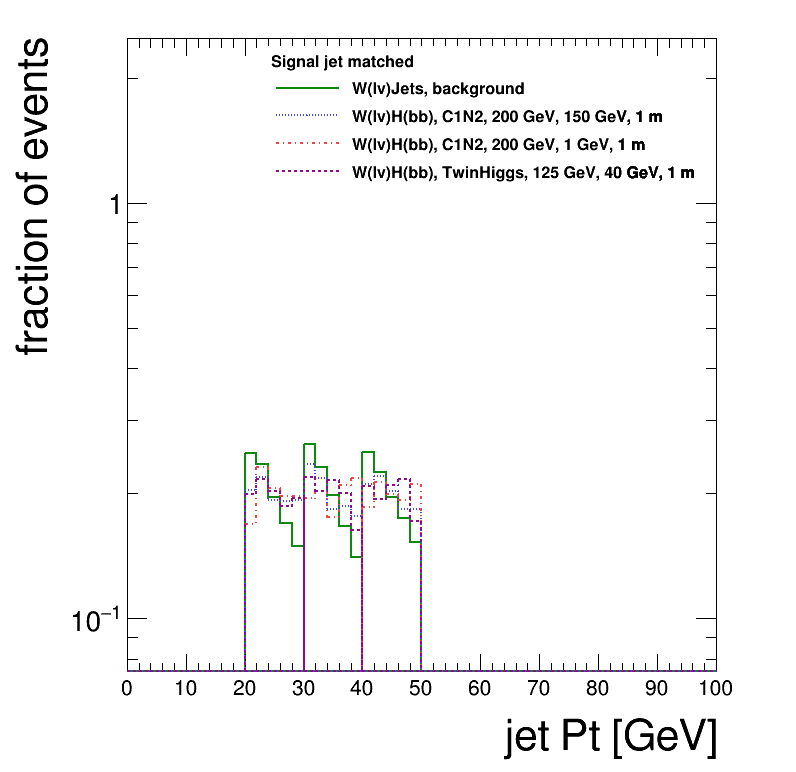

In [27]:
c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.33,0.76,0.78,0.94)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)


i = 0
ht = {}


for k,v in tree.items(): 
    print(k,v)

    ht[k] = {}
    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
        
        #plotting per jet

        j_gamma_all = pf_jet_pt[k][pt_str]

        print(j_gamma_all[:10])

        ht[k][pt_str] = create_TH1D( j_gamma_all, axis_title=['jet Pt [GeV]', 'fraction of events'], name="", binning=[50,-0,100])
        ht[k][pt_str].SetLineStyle(stys[k])
        ht[k][pt_str].SetLineColor(cols[k])
        ht[k][pt_str].SetMarkerColor(cols[k])
        ht[k][pt_str].GetXaxis().SetLabelSize(0.03)
        ht[k][pt_str].GetYaxis().SetLabelSize(0.04)
        ht[k][pt_str].SetMaximum(1e+1*(ht[k][pt_str].GetMaximum()))
    #     ht[k].SetMaximum(2*(ht[k].GetMaximum()))

        ht[k][pt_str].DrawNormalized('same')

        if pt_str=='20_30':
            leg.AddEntry(ht[k][pt_str], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched')
    else:
        leg.SetHeader('Signal jet not matched')

    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_pt_match_'+str(match)+'_pt_binned.png')

## pf jet time

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[ 0.01224654  0.24839108  3.899583   -0.4805095          nan         nan
         nan  0.21739122  2.1274784   0.13710472]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[ 0.73725516 -0.21048005  1.1807626   1.0858241   3.9571044   1.599758
  4.000818           nan  1.4349211          nan]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[ 2.7198832   4.1410747   0.9906299   7.6825323   2.1985788  -1.098471
         nan  0.99318075  2.3209498          nan]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18313a5080>
[2.6988585         nan 0.9107999         nan 1.2401066  0.07070051
 0.39984107        nan 1.5501257  2.4720328 ]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[-0.7465901  -0.75142443 -0.7351578  -0.28294793  0.5219346          nan
  0.36149105  0.9821043   0.29443207 -0.43456113]
W(lv)H(bb), C1N2, 200 GeV, 1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_time_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_time_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_time_match_1_pt_range_40_50.png has been created


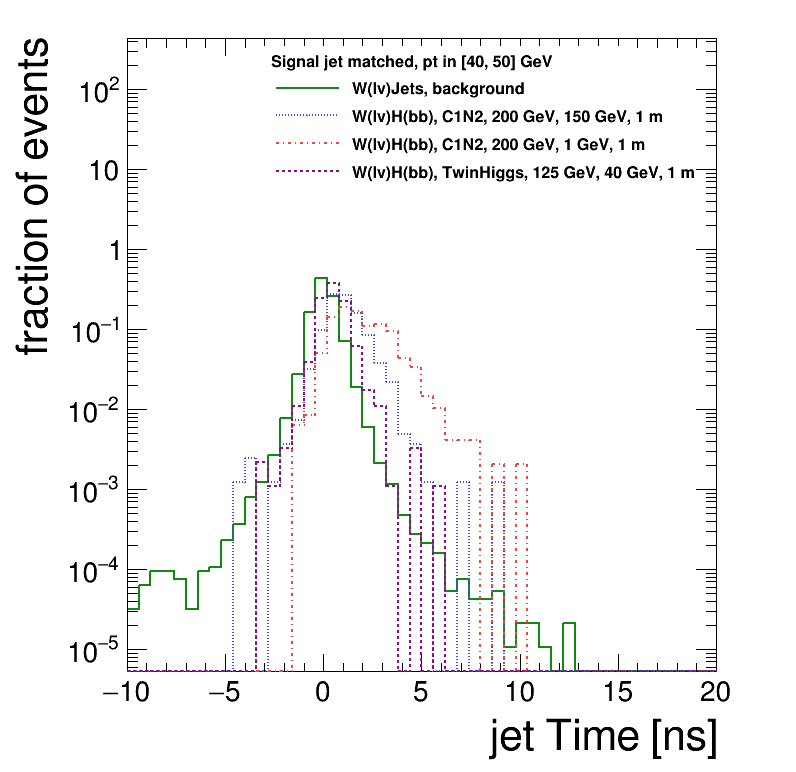

In [34]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}

    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_gamma_all = pf_jet_time[k][pt_str]

        print(j_gamma_all[:10])

        ht[k] = create_TH1D( j_gamma_all, axis_title=['jet Time [ns]', 'fraction of events'], name="", binning=[50,-10,20])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(1e+3*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)

    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_time_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

## pf jet track momentum fraction

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[0.06384943 0.18376368 0.29813704 0.20482473 0.8935306  0.22830135
 0.4606761  0.         0.5708025  0.0894006 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[0.08972866 0.08035415 0.         0.42919755 0.         0.06157725
 0.         0.37089482 0.05306605 0.05732469]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[0.1269834  0.08681597 0.06608511 0.06861803 0.14090323 0.03985906
 0.03481609 0.42330742 0.03490457 0.04992475]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18313a5080>
[0.         0.07465062 0.         0.08174346 0.2687538  0.
 0.         0.078453   0.03853316 0.09755925]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[0.47490194 0.86829835 0.6062091  0.47820142 0.8446529  0.7647347
 0.44842044 0.13528132 0.3453029  0.37466446]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_track_momentum_fraction_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_track_momentum_fraction_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_track_momentum_fraction_match_1_pt_range_40_50.png has been created


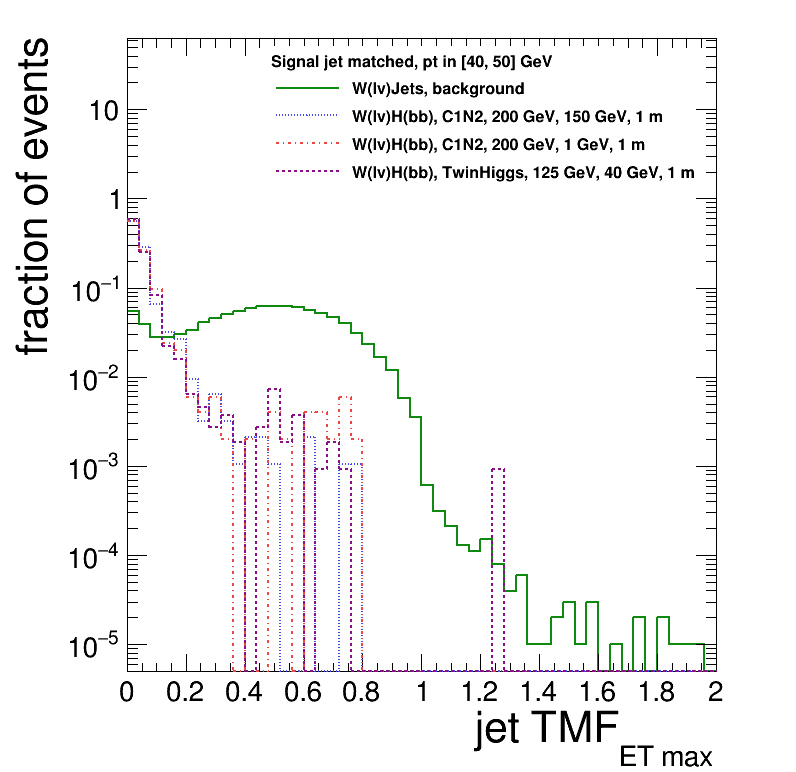

In [35]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}


    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_gamma_all = pf_jet_tmf_et[k][pt_str]

        print(j_gamma_all[:10])

        ht[k] = create_TH1D( j_gamma_all, axis_title=['jet TMF_{ET max}', 'fraction of events'], name="", binning=[50,-0,2])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(1e+3*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)
        
    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_track_momentum_fraction_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

## pf jet CHEF

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[0.27823916 0.44112927 0.6941291  0.42513397 0.05218702 0.79932654
 0.791325   0.09961585 0.5835475  0.04130923]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[0.39012882 0.01067169 0.04074198 0.498469   0.0444571  0.02624215
 0.01519152 0.7767163  0.24583408 0.2241556 ]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[0.04265025 0.18744893 0.43027946 0.15246947 0.03461617 0.08355951
 0.0897593  0.67411894 0.19825697 0.03539587]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18313a5080>
[0.15733877 0.01819997 0.02754475 0.04278385 0.25370386 0.21308666
 0.1906826  0.07828214 0.08523474 0.15113552]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[0.6675104  0.09745347 0.69896364 0.56518453 0.03375978 0.13207382
 0.6228058  0.19588569 0.49755958 0.39969522]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_chef_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_chef_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_chef_match_1_pt_range_40_50.png has been created


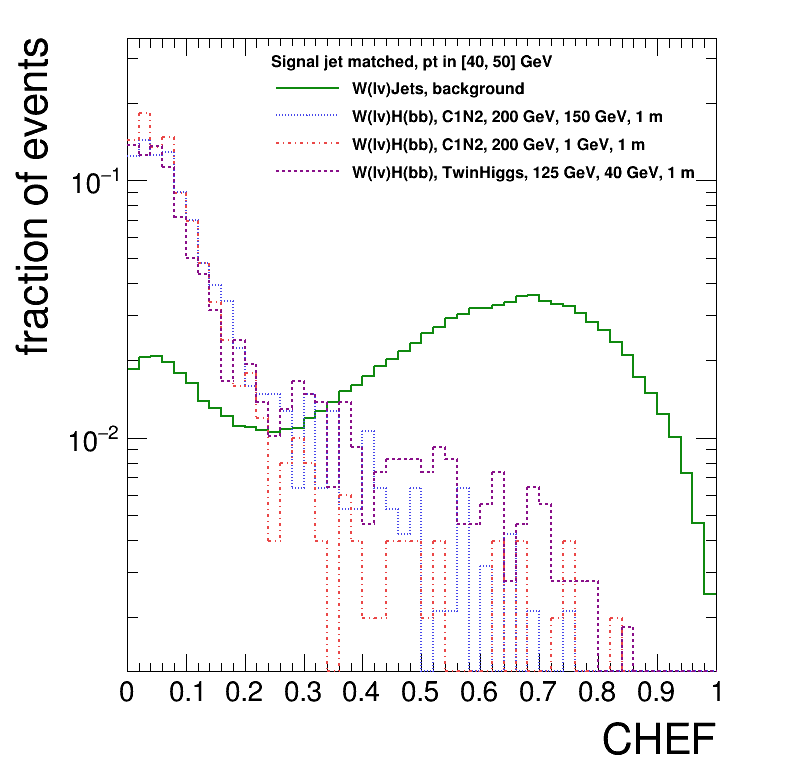

In [36]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}


    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_hovere_all = pf_jet_chef[k][pt_str]

        print(j_hovere_all[:10])

        ht[k] = create_TH1D( j_hovere_all, axis_title=['CHEF', 'fraction of events'], name="", binning=[50,-0,1])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(10*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)
        
    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_chef_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

## pf jet HoverE

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[ 0.3855005   0.918932    3.7823367   1.3330547   1.0050505   9.263632
 13.422326    0.11063705  5.2445307   0.21753114]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[1.2221787  0.28015625 0.04247239 1.1237944  1.3700047  0.35495424
 1.3301766  5.0094905  0.46301648 2.524692  ]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[0.06971551 2.3398068  1.1473842  0.8777211  1.7032535  1.0081905
 2.436932   2.968096   0.7316462  2.2959917 ]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18313a5080>
[ 0.80888563  7.8903475   2.0399559  26.961672    0.86139387  0.8449238
  1.923582   15.086673    0.5058862   0.9396095 ]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[2.007613   1.1497937  2.0125902  0.06135617 3.2166169  1.6511543
 2.3558025  0.9902856  0.6658204  6.9071217 ]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_h_over_e_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_h_over_e_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_h_over_e_match_1_pt_range_40_50.png has been created


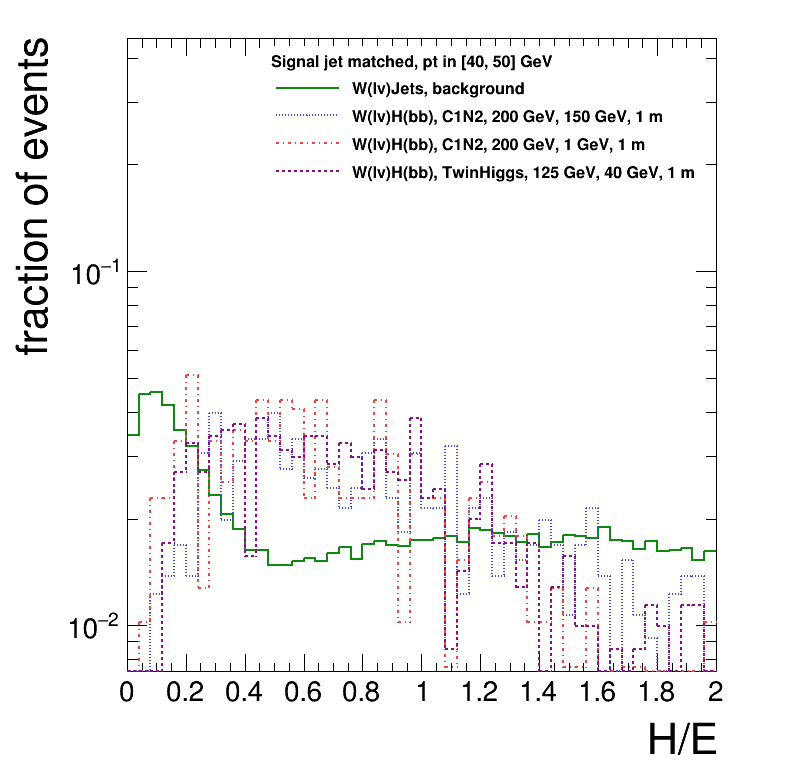

In [37]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}


    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_hovere_all = pf_jet_h_over_e[k][pt_str]

        print(j_hovere_all[:10])

        ht[k] = create_TH1D( j_hovere_all, axis_title=['H/E', 'fraction of events'], name="", binning=[50,-0,2])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(10*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)
        
    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_h_over_e_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

## pf jet pt tracks

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[ 2.776814   5.2274556 10.908295   5.8985934 25.790932   9.668895
 13.371137   0.        18.39015    3.5996878]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[ 3.319552   1.7550226  0.        11.470753   0.         2.713465
  0.         9.973294   1.5880913  1.590747 ]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18312fd0b8>
[ 9.22869    5.8032684  1.8029184  3.104557   7.170446   2.2002914
  1.1254221 16.037071   2.0600746  2.1857033]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f18313a5080>
[ 0.         1.8432302  0.         2.4038103 14.27215    0.
  0.         2.7424822  1.1241472  6.0525723]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7f183f5edf28>
[27.205477 25.241884 21.504242 15.029232 32.052635 35.90187  16.119343
  4.239681 11.435447 18.409374]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7f1831549470>
[ 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_trk_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_trk_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_pt_trk_match_1_pt_range_40_50.png has been created


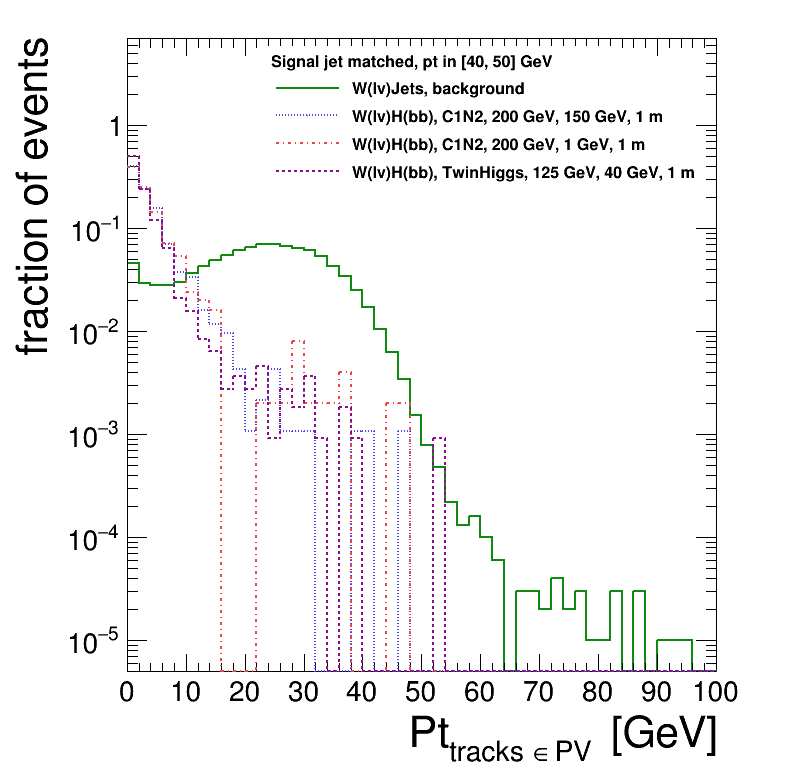

In [39]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}


    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_hovere_all = pf_jet_pt_trk[k][pt_str]

        print(j_hovere_all[:10])

        ht[k] = create_TH1D( j_hovere_all, axis_title=['Pt_{tracks #in PV } [GeV]', 'fraction of events'], name="", binning=[50,-0,100])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(100*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)

    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_pt_trk_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

## pf jet delta R

W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fbb6b7e1208>
[2.8262487e-01 8.5752852e-02 1.0215771e-01 6.5935150e-02 1.1197926e-02
 9.8489672e-02 4.8083279e-02 1.5000000e+01 7.4456312e-02 3.6531979e-01]
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbb6896dbe0>
[2.8593978e-01 3.6034939e-01 1.5000000e+01 1.8140498e-01 1.5000000e+01
 3.2104629e-01 1.5000000e+01 7.5841374e-03 2.4778058e-01 2.6162484e-01]
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbb5a674080>
[0.1120123  0.22222252 0.2034718  0.08501572 0.24604034 0.22726236
 0.36315167 0.13642909 0.3268024  0.28913927]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m <TTree b'SusyLLPTree' at 0x7fbb5a718080>
[15.          0.36749187 15.          0.26084238  0.21533293  0.44612098
  0.49374303  0.36784342  0.18778662  0.13357106]
W(lv)Jets, background <TTree b'SusyLLPTree' at 0x7fbb6b7e1208>
[0.09107672 0.02038164 0.02281572 0.05726896 0.0096904  0.02344033
 0.00640277 0.01561007 0.05676134 0.0276

Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_delta_r_match_1_pt_range_20_30.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_delta_r_match_1_pt_range_30_40.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20191023/pf_jet_delta_r_match_1_pt_range_40_50.png has been created


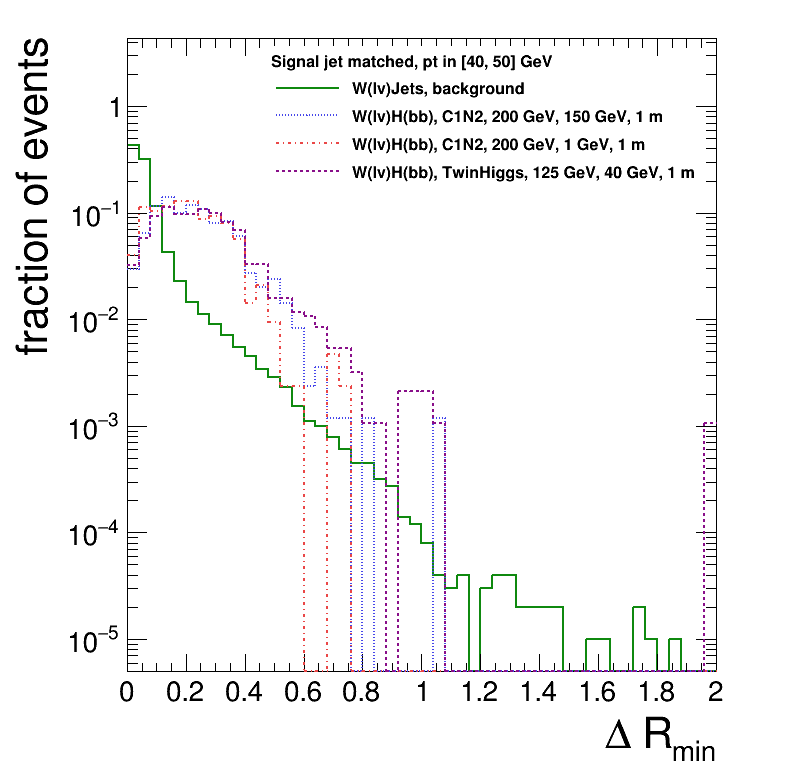

In [5]:
for pt_range in pt_ranges:
    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'
    
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)


    i = 0
    ht = {}


    for k,v in tree.items(): 
        print(k,v)

        #plotting per jet

        j_hovere_all = pf_jet_delta_r[k][pt_str]

        print(j_hovere_all[:10])

        ht[k] = create_TH1D( j_hovere_all, axis_title=['#Delta R_{min}', 'fraction of events'], name="", binning=[50,-0,2])
        ht[k].SetLineStyle(stys[k])
        ht[k].SetLineColor(cols[k])
        ht[k].SetMarkerColor(cols[k])
        ht[k].GetXaxis().SetLabelSize(0.04)
        ht[k].GetYaxis().SetLabelSize(0.04)
        ht[k].SetMaximum(10*(ht[k].GetMaximum()))

        ht[k].DrawNormalized('same')

        leg.AddEntry(ht[k], k)

        i += 1

    if match :
        leg.SetHeader('Signal jet matched, ' +pt_head_str)
    else:
        leg.SetHeader('Signal jet not matched, ' +pt_head_str)

    leg.Draw()

    c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(out_dir+'pf_jet_delta_r_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

# pf jet ROC

In [12]:
### ROC curve
var_pf = [pf_jet_delta_r, pf_jet_h_over_e, pf_jet_chef, pf_jet_tmf_et ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'], ['H/E','Events'],['CHEF','Events'],['PFJet TMF_{MAX}','Events']  ]
name_pf = ['pfjetMinDeltaRPVTracks','HoverE','CHEF','pfjetGammaMax_ET'  ]
bins_pf = [[50,0,10],[50,0,1.5],[50,0,1.5],[50,0,1.5],[50,0,10]]
maxs_pf = [10, 50, 1.5, 1.5, 1.5]

sig_keys = ['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m',]
# sig_keys = ['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m', 'W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m', 'W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'W(lv)Jets, background'
calo = 0

pt_bins = 1 # diff pt in one plot for each variable, or same pt range for all variable

if pt_bins:
    
#     for pt_range in pt_ranges:
#         pt_str = str(pt_range[0])+'_'+str(pt_range[1])
#         pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'

            
    for sig_k in sig_keys:
        c = rt.TCanvas('c','c', 800, 800)
        leg = rt.TLegend(0.48,0.19,0.86,0.34)
        leg.SetTextSize(0.022)
        leg.SetBorderSize(0)
        leg.SetEntrySeparation(0.01)

        gr = {}

        if calo:
            var = var_calo
            name = name_calo
            axis = axis_calo
            maxs = maxs_calo
        else:
            var = var_pf
            name = name_pf
            axis = axis_pf
            maxs = maxs_pf
            
        for i in range(len(var)):
    #         v = var[i]
            thre = maxs[i]*np.array(range(1,1000))/1000.0
    #         print(np.max(thre),np.min(thre))
            print(name[i])

            eff = {}
            for k in tree.keys():

                for pt_range in pt_ranges:
                    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
                    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'

                    print(sig_k,i, name[i],k,pt_range)

pfjetMinDeltaRPVTracks
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)Jets, background [20, 30]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)Jets, background [30, 40]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)Jets, background [40, 50]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [20, 30]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [30, 40]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m [40, 50]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [20, 30]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m [30, 40]
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 0 pfjetMinDeltaRPVTracks W(lv)H(bb), C1N2, 200 

pfjetMinDeltaRPVTracks
W(lv)Jets, background 423689
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 1668
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m 427
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 1938
999
[0.95508498 0.88091265 0.80108759 0.72302326 0.64781007 0.57796403
 0.5131783  0.45412555 0.4007751  0.35355178]
0.003113132509930633
0.9550849797847005
0.003113132509930633
[0.99793602 0.99329205 0.98503612 0.97987616 0.97058824 0.95304438
 0.94272446 0.92414861 0.90557276 0.88286894]
0.11197110423116616
0.9979360165118679
HoverE
W(lv)Jets, background 415862
W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m 1667
W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m 422
W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m 1927
999
[0.02177165 0.04502696 0.06627679 0.08346038 0.09788343 0.1100846
 0.1207564  0.13052407 0.13971462 0.14878734]
0.02177164540159957
0.9919997499170398
0.02177164540159957
[0.00311365 0.02023871 0.04411002 0.06538661 0.08822003 0.12195122
 0.15464453 0.17955371 0.20550078 0.23196679]
0.0031136481577581734


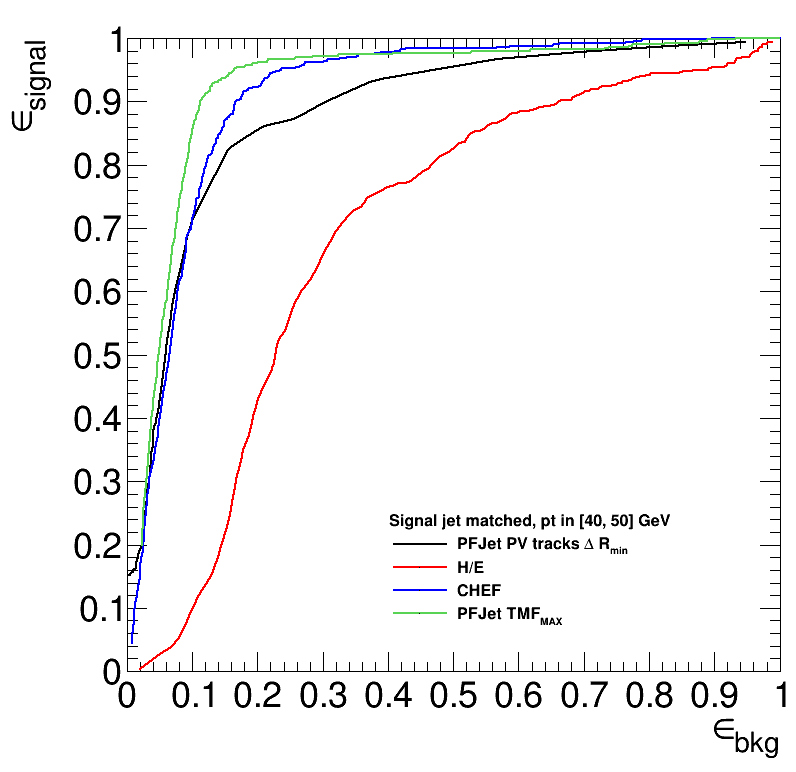

In [37]:
### ROC curve
var_pf = [pf_jet_delta_r, pf_jet_h_over_e, pf_jet_chef, pf_jet_tmf_et ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'], ['H/E','Events'],['CHEF','Events'],['PFJet TMF_{MAX}','Events']  ]
name_pf = ['pfjetMinDeltaRPVTracks','HoverE','CHEF','pfjetGammaMax_ET'  ]
bins_pf = [[50,0,10],[50,0,1.5],[50,0,1.5],[50,0,1.5],[50,0,10]]
maxs_pf = [10, 50, 1.5, 1.5, 1.5]

# sig_keys = ['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m',]
sig_keys = ['W(lv)H(bb), TwinHiggs, 125 GeV, 40 GeV, 1 m', 'W(lv)H(bb), C1N2, 200 GeV, 150 GeV, 1 m', 'W(lv)H(bb), C1N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'W(lv)Jets, background'
calo = 0

pt_bins = 0 # diff pt in one plot for each variable, or same pt range for all variable

if not pt_bins:

    for pt_range in pt_ranges:
        pt_str = str(pt_range[0])+'_'+str(pt_range[1])
        pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'

            
        for sig_k in sig_keys:
            c = rt.TCanvas('c','c', 800, 800)
            leg = rt.TLegend(0.48,0.19,0.86,0.34)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)

            gr = {}

            if calo:
                var = var_calo
                name = name_calo
                axis = axis_calo
                maxs = maxs_calo
            else:
                var = var_pf
                name = name_pf
                axis = axis_pf
                maxs = maxs_pf
            for i in range(len(var)):
        #         v = var[i]
                thre = maxs[i]*np.array(range(1,1000))/1000.0
        #         print(np.max(thre),np.min(thre))
                print(name[i])
                
                eff = {}
                for k in tree.keys():

                
                    v = var[i][k][pt_str]
                    print(k,len(v))
                    if len(v)==0:
                        print('no')
                        eff[k] = []
                        for th in thre:
                            if 'MinDeltaR' in name[i]:
                                eff[k].append(1.0)
                            else:
                                eff[k].append(1.0)
                        eff[k] = np.array(eff[k])
                    else:
                        eff[k] = []
                        for th in thre:
                            if 'MinDeltaR' in name[i]:
                                eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
                            else:
                                eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
                        eff[k] = np.array(eff[k])
                #     Plotting ROC curve
                gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
                print(len(eff[qcd_key]))
                print(eff[qcd_key][:10])
                print(min(eff[qcd_key]))
                print(max(eff[qcd_key]))
                print(min(eff[qcd_key]))
                print(eff[sig_k][:10])
                print(min(eff[sig_k]))
                print(max(eff[sig_k]))
                gr[name[i]].SetLineColor(std_color_list[i])
                gr[name[i]].SetLineWidth(2)
                gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
                gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

                leg.AddEntry(gr[name[i]],axis[i][0])

                gr[name[i]].Draw('ac' if i==0 else 'c')


            if match :
                leg.SetHeader('Signal jet matched, ' +pt_head_str)
            else:
                leg.SetHeader('Signal jet not matched, ' +pt_head_str)

            leg.Draw()
        #     c.SetLogx()
            c.Draw()
            c.SaveAs(out_dir+sig_k+'_pfROC_match_'+str(match)+'_pt_range_'+str(pt_str)+'.png')

else:
    
#     for pt_range in pt_ranges:
#         pt_str = str(pt_range[0])+'_'+str(pt_range[1])
#         pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'

            
    for sig_k in sig_keys:
        c = rt.TCanvas('c','c', 800, 800)

        if calo:
            var = var_calo
            name = name_calo
            axis = axis_calo
            maxs = maxs_calo
        else:
            var = var_pf
            name = name_pf
            axis = axis_pf
            maxs = maxs_pf
            
        for i in range(len(var)):
    #         v = var[i]
            thre = maxs[i]*np.array(range(1,1000))/1000.0
    #         print(np.max(thre),np.min(thre))
            print(sig_k,name[i])
        
            eff = {}
            for k in tree.keys():

                eff[k] = {}
                for pt_range in pt_ranges:
                    pt_str = str(pt_range[0])+'_'+str(pt_range[1])
                    pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'

                    v = var[i][k][pt_str]
                    print(k,len(v))
                    if len(v)==0:
                        print('no')
                        eff[k][pt_str] = []
                        for th in thre:
                            if 'MinDeltaR' in name[i]:
                                eff[k][pt_str].append(1.0)
                            else:
                                eff[k][pt_str].append(1.0)
                        eff[k][pt_str] = np.array(eff[k][pt_str])
                    else:
                        eff[k][pt_str] = []
                        for th in thre:
                            if 'MinDeltaR' in name[i]:
                                eff[k][pt_str].append(1.0*np.count_nonzero(v>th)/len(v))
                            else:
                                eff[k][pt_str].append(1.0*np.count_nonzero(v<th)/len(v))
                        eff[k][pt_str] = np.array(eff[k][pt_str])
                        
            #     Plotting ROC curve
            leg = rt.TLegend(0.48,0.19,0.86,0.34)
            leg.SetTextSize(0.022)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)
            
            gr = {}
            cnt=1
            for pt_range in pt_ranges:
                pt_str = str(pt_range[0])+'_'+str(pt_range[1])
                pt_head_str = 'pt in ['+str(pt_range[0])+', '+str(pt_range[1])+'] GeV'    

                gr[pt_str] = create_TGraph(eff[qcd_key][pt_str],eff[sig_k][pt_str],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])

                gr[pt_str].SetLineColor(std_color_list[cnt])
                gr[pt_str].SetLineWidth(2)
                gr[pt_str].GetYaxis().SetRangeUser(0.0, 1.0)
                gr[pt_str].GetXaxis().SetLimits(0.0, 1.0)

                leg.AddEntry(gr[pt_str],pt_head_str)

                gr[pt_str].Draw('ac' if cnt==1 else 'c')
    
                cnt += 1

            if match :
                leg.SetHeader('Signal jet matched, ' +axis[i][0])
            else:
                leg.SetHeader('Signal jet not matched, ' +axis[i][0])

            leg.Draw()
        #     c.SetLogx()
            c.Draw()
            c.SaveAs(out_dir+sig_k+'_pfROC_match_'+str(match)+'_'+name[i]+'_pt_binned.png')    